<a href="https://colab.research.google.com/github/ahmedhisham73/AI_in_healthcare/blob/main/monai_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

     |████████████████████████████████| 584 kB 3.9 MB/s 
     |████████████████████████████████| 221 kB 38.8 MB/s 


In [4]:
!nvidia-smi

Thu Dec  9 12:29:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    MapTransform,
    Randomizable,
    AddChannel,
    AddChanneld,
    Compose,
    LoadImage,
    LoadImaged,
    Lambda,
    Lambdad,
    RandSpatialCrop,
    RandSpatialCropd,
    ToTensor,
    ToTensord,
    Orientation, 
    Rotate
)
print_config()

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



MONAI aims at providing a comprehensive medical image specific transformations. These currently include, for example:

- LoadImage: Load medical specific formats file from provided path
- Spacing: Resample input image into the specified pixdim
- Orientation: Change the image’s orientation into the specified axcodes
- RandGaussianNoise: Perturb image intensities by adding statistical noises
- NormalizeIntensity: Intensity Normalization based on mean and standard deviation
- Affine: Transform image based on the affine parameters
- Rand2DElastic: Random elastic deformation and affine in 2D
- Rand3DElastic: Random elastic deformation and affine in 3D

In [6]:
#set file names 
fn_keys=('img','seg')

In [7]:
#create a root file directory 
root_dir = tempfile.mkdtemp()
filenames = []

In [8]:
for i in range(5):
    im, seg = create_test_image_3d(256, 256, 256, num_objs=25, rad_max=50)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

Transforms in MONAI are callable objects accepting inputs from initial data in a dataset or previous transforms. 


We can create and call these directly without any infrastructure or system setup as components in MONAI are designed to be as decoupled as possible. For example we can load one of our Nifti files directly by creating the transform and calling it.



Transforms are composed with Compose to create a sequence of operations

Compose itself being a transform we can also call it directly. 



The type of img here is numpy.ndarray so to convert to a Pytorch tensor as part of a training data pipeline we'd have ToTensor as the last transform in our sequence

In [9]:
trans = Compose([LoadImage(image_only=True), AddChannel(), ToTensor()])

In [10]:
img = trans(filenames[0]["img"])
print(type(img), img.shape, img.get_device())

<class 'torch.Tensor'> torch.Size([1, 256, 256, 256]) -1


We can define our own custom transform operation in a number of ways. If a simple callable is used as an operator, Lambda can be used to wrap it as a transform. We define in this example a transform to sum the image in the 1st (width) dimension to produce a 2D image:

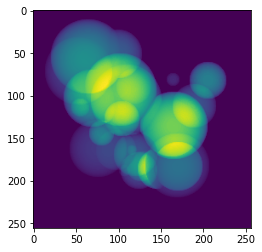

In [11]:
def sum_width(img):
    return img.sum(1)

trans = Compose([LoadImage(image_only=True), AddChannel(), Lambda(sum_width)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

Creating a subclass of Transform is the second method, and this has the advantage of being able to define attributes with the instantiated objects. Let's define a class to sum in a chosen dimension, and use it to sum in the 2nd (height) dimension:

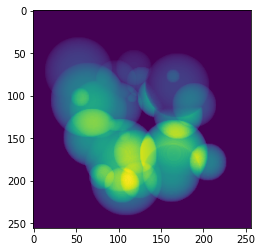

In [12]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

trans = Compose([LoadImage(image_only=True), AddChannel(), SumDimension(2)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

All of these example transforms so far have been deterministic, to define transforms which perform some stochastic operation on input data we want to also inherit from Randomizable. This class is used to randomize variables but also distinguish from deterministic transforms. We'll see why this is important later in caching data loaders.

In this class we have a numpy.random.RandomState object to provide stochastic values. This can be replaced using Randomizable.set_random_state() to control the randomization process. The randomize() method is responsible for determining if the random operation is to be performed based on the prob probability member, then creates the random noise array if so. This functionality is in this method so that it can be called by Compose or other external controllers.

For now lets define a simple transform to add noise.

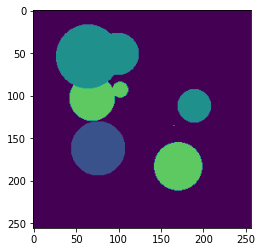

In [13]:
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = 0

    def randomize(self, data: np.ndarray) -> None:
        self._noise = 0

        if self.R.random() < self.prob:
            noise_array = self.R.rand(*data.shape[1:])[None]
            self._noise = (noise_array * self.max_add).astype(data.dtype)

    def add_noise(self, img: np.ndarray) -> np.ndarray:
        return img + self._noise

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize(img)
        return self.add_noise(img)

trans = Compose([LoadImage(image_only=True), AddChannel(), RandAdditiveNoise()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, 128])

So far we have seen transforms which are applied to individual Numpy arrays, however for most training schemes a pipeline with multiple values is needed. To address this MONAI includes transforms for operating on dictionaries of arrays, one for each equivalent array transform. These can be applied to named values in an input dictionary while leaving unnamed values untouched, for example adding noise to an image while leaving the associated label image untouched.

Earlier in the notebook we imported the dictionary equivalent transforms which have a d appended to their names, we'll use those transforms in this section. The keys argument in LoadNiftid is used to state which keys contain paths to Nifti files, all other values in the input dictionary will be retained. With this set we can look at the keys returned when calling the transform:

In [14]:
trans = LoadImaged(keys=fn_keys)
data = trans(filenames[0])
print(list(data.keys()))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


Lambdad applies the given callable to each array named by keys separately. We can use this to define transforms operating on different named values in the dictionary at different points in the sequence:

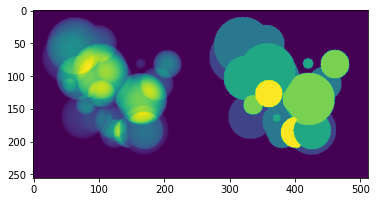

In [15]:
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

trans = Compose([LoadImaged(fn_keys), AddChanneld(fn_keys), Lambdad(("img",), sum_width), 
                 Lambdad(("seg",), max_width)])

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), seg[0])))

set_random_state sets the state of the delegate and the current object
randomize delegates the randomization to the RandAdditiveNoise instance
__call__ causes the delegate to randomize then applies the transform to each named member of the dictionary. The delegate transform is randomized only once, this ensures the same random field is added to each named member of the dictionary, a slightly different implementation adding a per-key random field would be needed if this were the desired behaviou

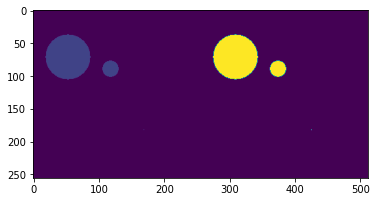

In [17]:
class RandAdditiveNoised(Randomizable, MapTransform):
    def __init__(
        self, keys: KeysCollection, prob: float = 0.5, max_add: float = 1.0
    ) -> None:
        super(Randomizable, self).__init__(keys)
        self.transform = RandAdditiveNoise(prob, max_add)

    def set_random_state(
        self, seed: Optional[int] = 1, state: Optional[np.random.RandomState] = None
    ) -> "RandAdditiveNoised":
        self.transform.set_random_state(seed, state)
        super().set_random_state(seed, state)
        return self

    def randomize(self, data: Optional[Any] = None) -> None:
        self.transform.randomize(data)

    def __call__(
        self, data: Mapping[Hashable, np.ndarray]
    ) -> Mapping[Hashable, np.ndarray]:
        self.randomize(data[monai.utils.first(self.keys)])

        d = dict(data)
        for key in self.keys:
            d[key] = self.transform.add_noise(d[key])
        return d

trans = Compose([LoadImaged(fn_keys), AddChanneld(fn_keys), RandAdditiveNoised(("img",))])
img = trans(filenames[0])

# We're adding random noise to the image, not the segmentation
plt.imshow(np.hstack([img["img"][0, 50], img["seg"][0, 50]])) 

In [18]:
images = [fn["img"] for fn in filenames]

transform = Compose([LoadImage(image_only=True), AddChannel(), ToTensor()])
ds = Dataset(images, transform)
img_tensor = ds[0]
print(img_tensor.shape, img_tensor.get_device())

torch.Size([1, 256, 256, 256]) -1


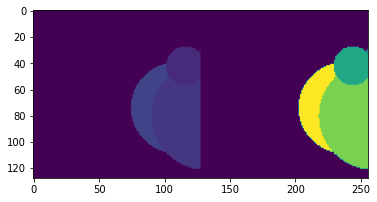

In [20]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose([LoadImage(image_only=True), AddChannel(), 
                         RandSpatialCrop((128, 128, 128), random_size=False), RandAdditiveNoise(), ToTensor()])
seg_transform = Compose([LoadImage(image_only=True), AddChannel(), 
                         RandSpatialCrop((128, 128, 128), random_size=False), ToTensor()])

ds = ArrayDataset(images, img_transform, segs, seg_transform)
im, seg = ds[2]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

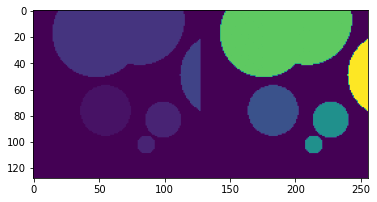

In [21]:
#or 

trans = Compose([LoadImaged(fn_keys), AddChanneld(fn_keys), RandAdditiveNoised(("img",)), 
                 RandSpatialCropd(fn_keys, (128, 128, 128), random_size=False), ToTensord(fn_keys)])

ds = Dataset(filenames, trans)
item = ds[0]
im, seg = item["img"], item["seg"]
plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

DataLoader will use five worker processes to load the actual data. MONAI provides a number of Dataset subclasses to improve the efficiency of this process. These and other features will be covered in subsequent labs.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['img', 'seg', 'img_meta_dict', 'seg_meta_dict', 'img_transforms', 'seg_transforms'] torch.Size([5, 1, 128, 128, 128])


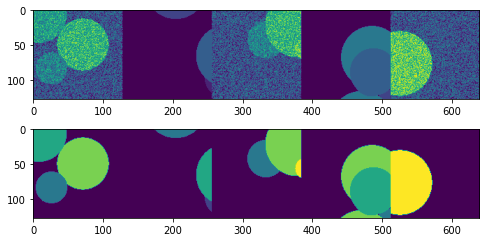

In [22]:
loader = DataLoader(ds, batch_size=5, num_workers=5)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

Create a transform which selects a patch from an input image of a given size and randomly chooses to transpose this data along randomly chosen axes. For example, this could produce an image where a patch in the center has been flipped in the horizontal direction while the rest of the image is left unchanged.

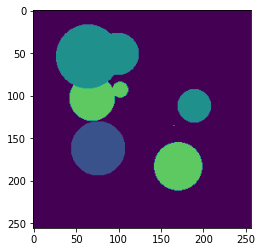

In [25]:
class RandFlipRect(Randomizable, Transform):
    """
    Define a transform to randomly transpose a patch of the input image along randomly chosen spatial dimensions. This 
    uses arguments `prob` for the probability the transform is applied, and `size` giving the size of the cube to flip.
    """
    



    def __init__(self, prob: float = 0.4, size: int = 100) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.size = size

    def random_flip(self, data: np.ndarray) -> None:
        if self.R.random() < self.prob:
            height = data.shape[1]
            width = data.shape[2]
            depth = data.shape[3]
            
            x = self.R.randint(0, height - self.size)
            y = self.R.randint(0, width - self.size)
            z = self.R.randint(0, depth - self.size)
            patch = data[..., x: x + self.size , y: y + self.size, z: z + self.size]
            
            if self.R.random() < 0.333:
                patch=patch[...,::-1,:,:]
                
            if self.R.random() < 0.333:
                patch=patch[...,::-1,:]
                
            if self.R.random() < 0.333:
                patch=patch[...,::-1]
                
            data[..., x: x + self.size , y: y + self.size, z: z + self.size]=patch
            
        return data

    def __call__(self, img: np.ndarray) -> np.ndarray:
        return self.random_flip(img)
    
trans = Compose([LoadImage(image_only=True), AddChannel(), RandFlipRect()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, img.shape[1]//2])

torch.Size([1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)
torch.Size([3, 1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)
torch.Size([2, 1, 200, 200, 200])
torch.float32 torch.int32
tensor(0.) tensor(1.)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)


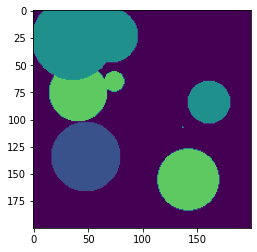

In [27]:
import torch
import torch
from monai.transforms import LoadImaged, CenterSpatialCropd, AddChanneld, ScaleIntensityd, CastToTyped, ToTensord


trans = Compose(
   [ LoadImaged(fn_keys, image_only=True),
        AddChanneld(fn_keys),
        CenterSpatialCropd(fn_keys, 200),
        ScaleIntensityd(["img"]),
        CastToTyped(fn_keys, (np.float32, np.int32)),
        ToTensord(fn_keys),]
    
)

data = trans(filenames[0])
img = data["img"]
seg = data["seg"]

print(img.shape)  # should be (1, 200, 200, 200)
print(img.dtype, seg.dtype)  # should be float32  int32
print(img.min(), img.max())  # should be 0.0 1.0
print(torch.unique(seg))  # should be [0 1 2 3 4 5]

plt.imshow(img[0, img.shape[1] // 2])

# construct dataset and dataloder here and iterate over batches, batch_size of 1 should be used


ds = Dataset(filenames,transform=trans)
loader= DataLoader(ds,batch_size=3)
for batch in loader:
    img = batch["img"]
    seg = batch["seg"]

    print(img.shape)  # should be (3, 1, 200, 200, 200) and (2, 1, 200, 200, 200) - first batch has 3, second has 2.
    print(img.dtype, seg.dtype)  # should be float32  int32
    print(img.min(), img.max())  # should be 0.0 1.0
    print(torch.unique(seg))  # should be [0 1 2 3 4 5]    

In [28]:
#datasets 

import time
import torch

import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset, PersistentDataset, SmartCacheDataset
from monai.apps import DecathlonDataset
from monai.transforms import (
    MapTransform,
)

print_config()

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



A MONAI Dataset is a generic dataset with a len property, getitem property, and an optional callable data transform when fetching a data sample.

We'll start by initializing some generic data, calling the Dataset class with the generic data, and specifying None for our transforms.



In [29]:
items = [{"data": 4}, 
         {"data": 9}, 
         {"data": 3}, 
         {"data": 7}, 
         {"data": 1},
         {"data": 2},
         {"data": 5}]
dataset = monai.data.Dataset(items, transform=None)

In [30]:
print(f"Length of dataset is {len(dataset)}")
for item in dataset:
    print(item)

Length of dataset is 7
{'data': 4}
{'data': 9}
{'data': 3}
{'data': 7}
{'data': 1}
{'data': 2}
{'data': 5}


Compatible with the PyTorch DataLoader
MONAI functionality should be compatible with the PyTorch DataLoader, although free to subclass from it if there is additional functionality that we consider key, which cannot be realized with the standard DataLoader class.

In [31]:
for item in torch.utils.data.DataLoader(dataset, batch_size=2):
    print(item)

{'data': tensor([4, 9])}
{'data': tensor([3, 7])}
{'data': tensor([1, 2])}
{'data': tensor([5])}


We'll create a custom transform called SquareIt, which will replace the corresponding value of the input's keys with a squared value. In our case, SquareIt(keys='data') will apply the square transform to the value of x['data'].

In [32]:
class SquareIt(MapTransform):
    def __init__(self, keys):
        MapTransform.__init__(self, keys)
        print(f"keys to square it: {self.keys}")
        
    def __call__(self, x):
        key = self.keys[0]
        data = x[key]
        output = {key: data ** 2}
        return output

square_dataset = Dataset(items, transform=SquareIt(keys='data'))
for item in square_dataset:
    print(item)

keys to square it: ('data',)
{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}


MONAI provides multi-thread versions of CacheDataset and LMDBDataset to accelerate these transformation steps during training by storing the intermediate outcomes before the first randomized transform in the transform chain. Enabling this feature could potentially give 10x training speedups in the Datasets experiment.

In [33]:
class SlowSquare(MapTransform):
    def __init__(self, keys):
        MapTransform.__init__(self, keys)
        print(f"keys to square it: {self.keys}")

    def __call__(self, x):
        time.sleep(1.0)
        output = {key: x[key] ** 2 for key in self.keys}
        return output

square_dataset = Dataset(items, transform=SlowSquare(keys='data'))

keys to square it: ('data',)


In [34]:
%time for item in square_dataset: print(item)

{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}
CPU times: user 30.8 ms, sys: 6.33 ms, total: 37.2 ms
Wall time: 7.01 s


Every time we run this loop we're going to get roughly 7 seconds to go through all of the items. If you were do this for 100 epochs, you're adding almost 12 extra minutes of load time to your total training loop. Let's look at ways that we can improve this time by utilizing caching

solution: 
Cache Dataset
When using CacheDataset the caching is done when the object is initialized for the first time, so the initialization is slower than a regular dataset.

By caching the results of non-random preprocessing transforms, it accelerates the training data pipeline. If the requested data is not in the cache, all transforms will run normally.

In [35]:
square_cached = CacheDataset(items, transform=SlowSquare(keys='data'))

keys to square it: ('data',)


Loading dataset: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


In [36]:
%timeit list(item for item in square_cached)

100000 loops, best of 5: 19.7 µs per loop


Persistent Caching
PersistentDataset allows for persistent storage of pre-computed values to efficiently manage larger than memory dictionary format data.

The non-random transform components are computed when first used and stored in the cache_dir for rapid retrieval on subsequent uses.

In [37]:
square_persist = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")
%time for item in square_persist: print(item)

keys to square it: ('data',)
{'data': 16}
{'data': 81}
{'data': 9}
{'data': 49}
{'data': 1}
{'data': 4}
{'data': 25}
CPU times: user 39.4 ms, sys: 6.25 ms, total: 45.6 ms
Wall time: 7.01 s


In [38]:
!ls my_cache

084852b1dabc721c099e14e1e8c28298.pt  755d77b67f942e5f1d1fda27fe93863a.pt
1257dfae3534518a1e7952d258c8792b.pt  89f8982b229a46956cd09956d7f5e575.pt
3d387df3250e7ce6ef754813a58de728.pt  a338dd9f228572a3cc1896c789569500.pt
65f06620bbaaf60cc1de433b6038ddfc.pt


In [39]:
square_persist_1 = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")
%timeit [item for item in square_persist_1]

keys to square it: ('data',)
The slowest run took 5.55 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 677 µs per loop


What common datasets are provided by MONAI?
To quickly get started with popular training data in the medical domain, MONAI provides several data-specific Datasets(like: MedNISTDataset, DecathlonDataset, etc.), which include downloading from our AWS storage, extracting data files and support generation of training/evaluation items with transforms.

The DecathlonDataset function leverages the features described throughout this notebook. These datasets are an extension of CacheDataset covered above.

In [40]:
dataset = monai.apps.DecathlonDataset(root_dir="./", task="Task09_Spleen", section="training", download=True)

Task09_Spleen.tar: 1.50GB [01:12, 22.3MB/s]                            


Downloaded: ./Task09_Spleen.tar
Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
Writing into directory: ./.


Loading dataset: 100%|██████████| 33/33 [00:24<00:00,  1.34it/s]


In [41]:
print(dataset.get_properties("numTraining"))
print(dataset.get_properties("description"))

{'numTraining': 41}
{'description': 'Spleen Segmentation'}


In [42]:
print(dataset[0]['image'].shape)
print(dataset[0]['label'].shape)

(512, 512, 55)
(512, 512, 55)


What Network and Network components does MONAI provide?
MONAI provides definitions for networks and their components that inherit directly from Pytorch Module, Sequential, etc. These general purpose networks include parameterized topologies that can easily be expanded are independent from rest of MONAI so networks can be used with existing training code.

MONAI includes the following submodules:

layers: defines low level layers, factories for selecting Pytorch and custom layers based on dimension and other arguments
blocks: mid-level building blocks defining specific reusable concepts networks are constructed from
nets: full network definitions for common architectures, eg. UNet, VNet, Densenet,

MONAI provides blocks for defining:

Convolution with activation and regularization
Residual units
Squeeze/excitation
Downsampling/upsampling
Subpixel convolutions

In [43]:
from monai.networks.layers import Conv, Act, split_args, Pool

In [44]:
print(Conv[Conv.CONV, 1])
print(Conv[Conv.CONV, 2])
print(Conv[Conv.CONV, 3])
print(Conv[Conv.CONVTRANS, 1])
print(Conv[Conv.CONVTRANS, 2])
print(Conv[Conv.CONVTRANS, 3])

<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv3d'>
<class 'torch.nn.modules.conv.ConvTranspose1d'>
<class 'torch.nn.modules.conv.ConvTranspose2d'>
<class 'torch.nn.modules.conv.ConvTranspose3d'>


In [45]:
print(Conv[Conv.CONV, 2](in_channels=1, out_channels=4, kernel_size=3))
print(Conv[Conv.CONV, 3](in_channels=1, out_channels=4, kernel_size=3))

Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))


In [46]:
print(Act[Act.PRELU])
Act[Act.PRELU](num_parameters=1, init=0.1)

<class 'torch.nn.modules.activation.PReLU'>


PReLU(num_parameters=1)

In [47]:
act_name, act_args = split_args(("prelu", {"num_parameters": 1, "init": 0.1}))
Act[act_name](**act_args)

PReLU(num_parameters=1)

Flexible Definition Networks
These APIs allow for flexible definitions of networks. Below we'll create a class called MyNetwork that utilizes Conv, Act, and Pool. Each Network requires an __init__ and a forward function

In [48]:
class MyNetwork(torch.nn.Module):
    
  def __init__(self, dims=3, in_channels=1, out_channels=8, kernel_size=3, pool_kernel=2, act="relu"):
    super(MyNetwork, self).__init__()
    # convolution
    self.conv = Conv[Conv.CONV, dims](in_channels, out_channels, kernel_size=kernel_size)
    # activation
    act_type, act_args = split_args(act)
    self.act = Act[act_type](**act_args)
    # pooling
    self.pool = Pool[Pool.MAX, dims](pool_kernel)
  
  def forward(self, x: torch.Tensor):
    x = self.conv(x)
    x = self.act(x)
    x = self.pool(x)
    return x

In [49]:
# default network instance
default_net = MyNetwork()
print(default_net)
print(default_net(torch.ones(3, 1, 20, 20, 30)).shape)

# 2D network instance
elu_net = MyNetwork(dims=2, in_channels=3, act=("elu", {"inplace": True}))
print(elu_net)
print(elu_net(torch.ones(3, 3, 24, 24)).shape)

# 3D network instance with anisotropic kernels
sigmoid_net = MyNetwork(3, in_channels=4, kernel_size=(3, 3, 1), act="sigmoid")
print(sigmoid_net)
print(sigmoid_net(torch.ones(3, 4, 30, 30, 5)).shape)


MyNetwork(
  (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (act): ReLU()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 9, 9, 14])
MyNetwork(
  (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (act): ELU(alpha=1.0, inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 11, 11])
MyNetwork(
  (conv): Conv3d(4, 8, kernel_size=(3, 3, 1), stride=(1, 1, 1))
  (act): Sigmoid()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([3, 8, 14, 14, 2])


We'll define a 2D UNet network with 2 hidden layers having outputs with 8 channels, and a bottom (bottleneck) layer producing outputs with 32 channels. The stride values state the stride for the initial convolution, ie. downsampling in down path and upsampling in up path and it'll transpose the convolutions used to implement upsampling.

In [50]:
net = monai.networks.nets.UNet(
    dimensions=2,  # 2 or 3 for a 2D or 3D network
    in_channels=1,  # number of input channels
    out_channels=1,  # number of output channels
    channels=[8, 16, 32],  # channel counts for layers
    strides=[2, 2]  # strides for mid layers
)

In [51]:
net = monai.networks.nets.UNet(
    dimensions=3,  
    in_channels=1,      
    out_channels=1,  
    channels=[8, 16, 32, 64],
    strides=[2, 2, 2],
    act=monai.networks.layers.Act.LEAKYRELU
)

task 01 
Write a transform that subtracts 1 from the input value
Combine the new Transform with the existing SlowSquare from above
Instantiate SmartCacheDataset with replacement rate of .2 and cache number of 5
Run SmartCache 5-times so that you can see the replacement values

In [56]:
from monai.data import SmartCacheDataset
from monai.transforms import Compose, MapTransform

class MinusOne(MapTransform):
    def __init__(self, keys):
        MapTransform.__init__(self, keys)
        print(f"keys to minus from: {self.keys}")

    def __call__(self, x):
        output = {key: x[key] - 1 for key in self.keys}
        return output

smart_transform = Compose([SlowSquare(keys='data', ), MinusOne(keys='data', )])    

smart_square  = monai.data.SmartCacheDataset(
    items, 
    transform=smart_transform, 
    replace_rate = .2,
    cache_num=5
)

%time for item in smart_square: print(item)

keys to square it: ('data',)
keys to minus from: ('data',)


Loading dataset: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

{'data': 24}
{'data': 8}
{'data': 80}
{'data': 48}
{'data': 15}
CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.12 ms


In [57]:
#Run through SmartCache replacement N-times
smart_square.start()

for i in range(5):
    print("\nCache: ", i)
    for item in smart_square: 
        print(item)
    smart_square.update_cache()
    
smart_square.shutdown()


Cache:  0
{'data': 24}
{'data': 8}
{'data': 80}
{'data': 48}
{'data': 15}

Cache:  1
{'data': 8}
{'data': 80}
{'data': 48}
{'data': 15}
{'data': 3}

Cache:  2
{'data': 80}
{'data': 48}
{'data': 15}
{'data': 3}
{'data': 0}

Cache:  3
{'data': 48}
{'data': 15}
{'data': 3}
{'data': 0}
{'data': 24}

Cache:  4
{'data': 15}
{'data': 3}
{'data': 0}
{'data': 24}
{'data': 8}


In [58]:
from monai.networks.nets import DenseNet121

net = DenseNet121(
    spatial_dims=2,
    in_channels=2,
    out_channels=3
)
print(net)

DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [59]:
import torch.nn as nn
from monai.networks.layers.factories import Conv
from monai.networks.nets import UNet


class MyUNet(UNet):
    def _get_down_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        conv_type = Conv[Conv.CONV, self.dimensions]
        return conv_type(in_channels, out_channels, self.kernel_size)


unet = MyUNet(2, 1, 1, [2, 4, 8, 16], [2, 2, 2])
print(unet)

MyUNet(
  (model): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
            (1): SkipConnection(
              (submodule): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
            )
            (2): Convolution(
              (conv): ConvTranspose2d(24, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.0, inplace=False)
                (A): PReLU(num_parameters=1)
              )
            )
          )
        )
        (2): Convolution(
          (conv): ConvTranspose2d(8, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)